# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Discussion](#discussion)
* [Conclusion](#conclusion)



## Introduction <a name="introduction"></a>

Moscow (city where I have spent 4 years of my life) is one of the largest cities in the world divided into more than 100 districts. Moscow is the city with growing prices for real estate and developing infrastructure. 

When I only moved to this city I knew nothing about catering infrastructure and prices for real estate in specific district. So this report will be useful for new comers to the city to identify the best place to live.

To make this choice easier this report will show a map split by real estate prices with clustering catering infrastructure accordingly.

## Data <a name="data"></a>

Based on definition of the issue below is data to be used in analysis:
* Moscow split by districts in .geojson found in GitHub (file was cleaned additionally)
* latest per square meter real estate price from one of the most popular Moscow real-estate web-site
* number of existing catering venues extracted from Forsquare API


*there are extra steps in data transformation to get data work due to Cyrillic

### Moscow .geojson

Let's create map with split by discricts.

1. Find the latitude & longitude of Moscow

In [2]:
# import library to convert an address into latitude and longitude values
from geopy.geocoders import Nominatim

In [3]:
# find the latitude & longitude of Moscow
address = 'Old Moscow'
geolocator = Nominatim(user_agent="moscow")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

2. Build map with center of Moscow

In [5]:
# import library to build map folium
import folium

In [9]:
# build map with center of Moscow
mow_map = folium.Map(location=[latitude, longitude], zoom_start=10,  titles='Moscow')
mow_map

3. Utilize geojson of Moscow

In [10]:
# import library json to work with json files
import json

In [12]:
# opening the file with determining encoding for Cyrillic
mow_geo = r'geojson_moscow.geojson'
with open(mow_geo, 'r', encoding='utf-8') as output:
    boundaries = json.load(output)

4. Build map of Moscow split by district

In [14]:
# build map of Moscow split by district by Choropleth
mow_map = folium.Map(location=[latitude, longitude], zoom_start=10,  titles='Moscow')
folium.Choropleth(
    geo_data=boundaries
).add_to(mow_map)
mow_map

### Price per square meter real estate

1. Grab data from web-site

In [15]:
# imoprt libraries required to work with data
import numpy as np 
import pandas as pd
import lxml

In [27]:
# read data from web-site
df_source = pd.read_html('https://www.irn.ru/rating/moscow/?segment=districts&param=IS&sort=value&currency=1#begin')[0]

In [28]:
df_working = df_source
df_working.head()

Рейтинг районов и метро по уровню цен на жильё, $/кв.м.  (www.irn.ru)     \
                                                     Unnamed: 0_level_1  №   
0                                                NaN                     1   
1                                                NaN                     2   
2                                                NaN                     3   
3                                                NaN                     4   
4                                                NaN                     5   

                                                                        \
  изм        районы                                              метро   
0 NaN     Остоженка                       Кропоткинская, Парк культуры   
1 NaN      Якиманка              Новокузнецкая, Полянка, Третьяковская   
2 NaN         Арбат  Александровский сад, Арбатская, Библиотека име...   
3 NaN  Центр Москвы  Китай-город, Кузнецкий мост, Лубянка, Охотный ...   
4 NaN      Тверской        Маяковская, Пушкинская, Тверская, Чеховская   

  РУБ  USD EUR         
        Апр 20 Мар 20  
0        5 394  -2,2%  
1        5 135  -2,1%  
2        4 949  -2,0%  
3        4 834  -1,7%  
4        4 611  -3,8%

2. Clean data

In [29]:
# restoring columns
df_working.columns = range(df_working.shape[1])

In [30]:
# drop unnnecessary columns
df_working.drop(0, axis=1, inplace=True)
df_working.drop(1, axis=1, inplace=True)
df_working.drop(2, axis=1, inplace=True)
df_working.drop(6, axis=1, inplace=True)

# rename coulmns
df_working.rename(columns={3: "District", 4: "Metro", 5: "Price"}, inplace=True)
df_working.head()

,District,Metro,Price
0,Остоженка,"Кропоткинская, Парк культуры",5 394
1,Якиманка,"Новокузнецкая, Полянка, Третьяковская",5 135
2,Арбат,"Александровский сад, Арбатская, Библиотека име...",4 949
3,Центр Москвы,"Китай-город, Кузнецкий мост, Лубянка, Охотный ...",4 834
4,Тверской,"Маяковская, Пушкинская, Тверская, Чеховская",4 611


In [33]:
# some Districts are empty, so it should be replaced by Metro and then we do not need Metro
df_working['District'] = np.where(pd.isnull(df_working['District']),df_working['Metro'],df_working['District'])
df_working.drop('Metro', axis=1, inplace=True)
df_working.head()

,District,Price
0,Остоженка,5 394
1,Якиманка,5 135
2,Арбат,4 949
3,Центр Москвы,4 834
4,Тверской,4 611


In [34]:
# there is Russian letter ё which is not popular and usually you would use e -> required to replace to be aligned with other data sources
df_working['District'].replace("ё", "е",regex=True, inplace=True)

In [35]:
# column District can contain several districts split by ', '  -> requierd to split
df_working1 = pd.concat([df_working['District'].str.split(', ', expand=True), df_working[['Price']]], axis=1)
df_working1.head()

,0,1,2,3,4,Price
0,Остоженка,None,None,None,None,5 394
1,Якиманка,None,None,None,None,5 135
2,Арбат,None,None,None,None,4 949
3,Центр Москвы,None,None,None,None,4 834
4,Тверской,None,None,None,None,4 611


In [36]:
# column District can contain several districts split by ': '  -> requierd to split
df_working_1_t = pd.concat([df_working1[[0]], df_working1[['Price']] ], axis=1)
df_working_1_t = pd.concat([df_working_1_t[0].str.split(': ', expand=True), df_working_1_t[['Price']]], axis=1)
df_working_1_t.head()

,0,1,Price
0,Остоженка,None,5 394
1,Якиманка,None,5 135
2,Арбат,None,4 949
3,Центр Москвы,None,4 834
4,Тверской,None,4 611


In [37]:
# creating one dataframe woth all discricts combined
df_working_0_1 = pd.concat([df_working_1_t[[0]], df_working_1_t[['Price']] ], axis=1)
df_working_0_1.rename(columns={0: "District", 5: "Price"}, inplace=True)
df_working_0_1.head()

,District,Price
0,Остоженка,5 394
1,Якиманка,5 135
2,Арбат,4 949
3,Центр Москвы,4 834
4,Тверской,4 611


In [38]:
df_working_0_2 = pd.concat([df_working_1_t[[1]], df_working_1_t[['Price']] ], axis=1)
df_working_0_2.dropna(inplace=True)
df_working_0_2.reset_index(drop=True, inplace=True)
df_working_0_2.rename(columns={1: "District"}, inplace=True)

df_working_1 = pd.concat([df_working1[[1]], df_working1[['Price']] ], axis=1)
df_working_1.dropna(inplace=True)
df_working_1.reset_index(drop=True, inplace=True)
df_working_1.rename(columns={1: "District"}, inplace=True)

df_working_2 = pd.concat([df_working1[[2]], df_working1[['Price']] ], axis=1)
df_working_2.dropna(inplace=True)
df_working_2.reset_index(drop=True, inplace=True)
df_working_2.rename(columns={2: "District"}, inplace=True)

df_working_3 = pd.concat([df_working1[[3]], df_working1[['Price']] ], axis=1)
df_working_3.dropna(inplace=True)
df_working_3.reset_index(drop=True, inplace=True)
df_working_3.rename(columns={3: "District"}, inplace=True)

df_working_4 = pd.concat([df_working1[[4]], df_working1[['Price']] ], axis=1)
df_working_4.dropna(inplace=True)
df_working_4.reset_index(drop=True, inplace=True)
df_working_4.rename(columns={4: "District"}, inplace=True)

In [39]:
# combinig all cleaned dataframes in one
frames = [df_working_0_2, df_working_1, df_working_2, df_working_3, df_working_4]
df_result = df_working_0_1.append(frames)
df_result.reset_index(drop=True, inplace=True)
df_result.head()

,District,Price
0,Остоженка,5 394
1,Якиманка,5 135
2,Арбат,4 949
3,Центр Москвы,4 834
4,Тверской,4 611


In [40]:
# price is string -> required to convert to integer
df_result['Price'] = df_result['Price'].str.replace('\s+','').astype(int)
df_result.head()

,District,Price
0,Остоженка,5394
1,Якиманка,5135
2,Арбат,4949
3,Центр Москвы,4834
4,Тверской,4611


### Catering venues Forsquare API

Having all districts required to collect data on catering venues using Foursquare API exploring venues in 'food' category.

1. Find district centers

In [42]:
district_list = []
for dist in df_result['District']:
    address = 'Москва район ' + str(dist)
    geolocator = Nominatim(user_agent="moscow")
    location = geolocator.geocode(address)
    
    district_list.append((
        str(dist), 
        location.latitude, 
        location.longitude, 
        ))
    
df_dis_working1 = pd.DataFrame(district_list)
df_dis_working1.columns = ['District', 'Latitude', 'Longitude']
df_dis_working1.head()

,District,Latitude,Longitude
0,Остоженка,55.737935,37.595576
1,Якиманка,55.738374,37.616913
2,Арбат,55.751199,37.589872
3,Центр Москвы,55.744543,37.651945
4,Тверской,55.762539,37.608913


2. Define all catering venues around the district

In [47]:
# import library to handle requests
import requests

In [43]:
# Foursquare credentials
CLIENT_ID = 'QZ05FP2N2D2LZB5LO2EYLQTKETFCWYJMGRPI3TR4QMQ3GWSE'
CLIENT_SECRET = 'SZZFM4VRZJ54CEEQJDLKMHQAIYKRCYRIALO1VASNUCXFDHFN' # your Foursquare Secret
VERSION = '20180605'

In [45]:
# limit of number of venues returned by Foursquare API
LIMIT = 100 
# define radius
radius = 2000
# define catering venues by category food
categoryId = '4d4b7105d754a06374d81259'

In [48]:
# collecting all catering venues for all districts
venues_list = []

for lat, lng, dist in zip(df_dis_working1['Latitude'], df_dis_working1['Longitude'], df_dis_working1['District']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}".format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            categoryId,
            LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    for venue in results:
        venues_list.append((
            dist,
            lat, 
            lng,
            venue['venue']['id'], 
            venue['venue']['name'], 
            venue['venue']['categories'][0]['id'],
            venue['venue']['categories'][0]['name'],
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],
            venue['venue']['location']['distance']
            ))

df_ven_working1 = pd.DataFrame(venues_list)
df_ven_working1.columns = ['District', 'Latitude', 'Longitude', 'Venue_ID', 'Venue_Name','Venue_Category_ID','Venue_Category_Name', 'Venue_Latitude', 'Venue_Longitude', 'Venue_Distance']
df_ven_working1.head()

,District,Latitude,Longitude,Venue_ID,Venue_Name,Venue_Category_ID,Venue_Category_Name,Venue_Latitude,Venue_Longitude,Venue_Distance
0,Остоженка,55.737935,37.595576,5c4c429f56c89f002cdce3d2,Rick’s,52e81612bcbc57f1066b79f1,Bistro,55.739702,37.596219,200
1,Остоженка,55.737935,37.595576,4c0b47be6071a593591de132,Жеральдин,4bf58dd8d48988d10c941735,French Restaurant,55.739102,37.597407,173
2,Остоженка,55.737935,37.595576,4c28759ffe6e2d7f153a533c,Академия,4bf58dd8d48988d16d941735,Café,55.737953,37.601877,394
3,Остоженка,55.737935,37.595576,587bac8ef22995732dcd490d,Cevicheria,4bf58dd8d48988d1ce941735,Seafood Restaurant,55.738684,37.605369,619
4,Остоженка,55.737935,37.595576,4bcb719b68f976b038206183,Эларджи,5293a7d53cf9994f4e043a45,Caucasian Restaurant,55.744585,37.595949,740


## Methodology <a name="methodology"></a>

First step of analysis is to indentify the disctibution of prices for real estate in Moscow using **choropleth map**, such map clearly shows the allocation of the full prices range by district. 
To do this we have to combine the map and prices per district.

In [50]:
# create a numpy array of length 6 and has linear spacing from the minium price to the maximum price
threshold_scale = np.linspace(df_result['Price'].min(),
                              df_result['Price'].max(),
                              6, dtype=int)

# change the numpy array to a list
threshold_scale = threshold_scale.tolist() 

In [52]:
# build map of Moscow split by district by Choropleth
mow_map = folium.Map(location=[latitude, longitude], zoom_start=10,  titles='Moscow')
folium.Choropleth(
    geo_data=boundaries,
    data=df_result,
    columns=['District', 'Price'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Square meter price USD',
    reset=True
).add_to(mow_map)
mow_map

Second step is to create clusters of catering venues using **k-means** to analyze easier the type venue.
To do this we have to identify the number of clusters first.

In [60]:
# import libraries to build plots
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt

# import library for K-means analysis
from sklearn.cluster import KMeans

In [53]:
# transpose table for further analysis
df_ven_working2 = pd.get_dummies(df_ven_working1[['Venue_Category_Name']], prefix="", prefix_sep="")
df_ven_working2.head()

,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belarusian Restaurant,Belgian Restaurant,...,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [54]:
# add District column to dataframe
df_ven_working2['District'] = df_ven_working1['District'] 

# move neighborhood column to the first column
fixed_columns = [df_ven_working2.columns[-1]] + list(df_ven_working2.columns[:-1])
df_ven_working2 = df_ven_working2[fixed_columns]
df_ven_working2.head()

,District,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belarusian Restaurant,...,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Остоженка,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Остоженка,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Остоженка,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Остоженка,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Остоженка,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# group rows by District and by taking the mean of the frequency of occurrence of each category
df_ven_working3 = df_ven_working2.groupby('District').mean().reset_index()
df_ven_working3.head()

,District,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belarusian Restaurant,...,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Академический,0.00,0.0,0.0,0.010526,0.0,0.000000,0.0,0.084211,0.0,...,0.0,0.0,0.0,0.00,0.00,0.010526,0.0,0.00,0.021053,0.00
1,Алексеевский,0.00,0.0,0.0,0.012346,0.0,0.012346,0.0,0.049383,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.00,0.012346,0.00
2,Алтуфьевский,0.00,0.0,0.0,0.000000,0.0,0.019231,0.0,0.057692,0.0,...,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.00,0.000000,0.00
3,Арбат,0.00,0.0,0.0,0.050000,0.0,0.020000,0.0,0.060000,0.0,...,0.0,0.0,0.0,0.01,0.00,0.010000,0.0,0.02,0.010000,0.01
4,Аэропорт,0.01,0.0,0.0,0.030000,0.0,0.000000,0.0,0.080000,0.0,...,0.0,0.0,0.0,0.00,0.01,0.010000,0.0,0.00,0.000000,0.00


In [58]:
# prepare dataframe for cluster analysis
df_grouped_clustering = df_ven_working3.drop('District', 1)

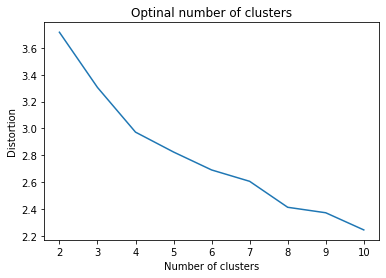

In [61]:
# define number of clusters by testing different numbers
wcss = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.plot(range(2, 11), wcss)
plt.title('Optinal number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

The main break is on 4 clusters, so 4 clusters will be used for further analysis.

In [62]:
# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_grouped_clustering)

For further analysis new dataframe created with the cluster as well as the top 10 venues for each district

In [63]:
# sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [64]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
df_dist_venues_sorted = pd.DataFrame(columns=columns)
df_dist_venues_sorted['District'] = df_ven_working3['District']

for ind in np.arange(df_ven_working3.shape[0]):
    df_dist_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_ven_working3.iloc[ind, :], num_top_venues)

df_dist_venues_sorted.head()

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Академический,Café,Caucasian Restaurant,Italian Restaurant,Bakery,Sushi Restaurant,Pizza Place,Japanese Restaurant,Eastern European Restaurant,Restaurant,Cafeteria
1,Алексеевский,Café,Pizza Place,Eastern European Restaurant,Middle Eastern Restaurant,Cafeteria,Bakery,Italian Restaurant,Caucasian Restaurant,Shawarma Place,Fast Food Restaurant
2,Алтуфьевский,Pizza Place,Fast Food Restaurant,Café,Sushi Restaurant,Cafeteria,Eastern European Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Burger Joint
3,Арбат,Russian Restaurant,Restaurant,Seafood Restaurant,Caucasian Restaurant,Italian Restaurant,Café,Bakery,Steakhouse,Asian Restaurant,Eastern European Restaurant
4,Аэропорт,Café,Pizza Place,Restaurant,Bakery,Italian Restaurant,Caucasian Restaurant,Fast Food Restaurant,Bistro,Asian Restaurant,Middle Eastern Restaurant


In [65]:
# add clustering labels
df_dist_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
df_dist_venues_sorted.head()

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Академический,Café,Caucasian Restaurant,Italian Restaurant,Bakery,Sushi Restaurant,Pizza Place,Japanese Restaurant,Eastern European Restaurant,Restaurant,Cafeteria
1,3,Алексеевский,Café,Pizza Place,Eastern European Restaurant,Middle Eastern Restaurant,Cafeteria,Bakery,Italian Restaurant,Caucasian Restaurant,Shawarma Place,Fast Food Restaurant
2,2,Алтуфьевский,Pizza Place,Fast Food Restaurant,Café,Sushi Restaurant,Cafeteria,Eastern European Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Burger Joint
3,0,Арбат,Russian Restaurant,Restaurant,Seafood Restaurant,Caucasian Restaurant,Italian Restaurant,Café,Bakery,Steakhouse,Asian Restaurant,Eastern European Restaurant
4,0,Аэропорт,Café,Pizza Place,Restaurant,Bakery,Italian Restaurant,Caucasian Restaurant,Fast Food Restaurant,Bistro,Asian Restaurant,Middle Eastern Restaurant


Based on prepared data it is required to make interpretation of each cluster examining one by one

In [69]:
# cluster 0
df_dist_venues_sorted.loc[df_dist_venues_sorted['Cluster Labels'] == 0, df_dist_venues_sorted.columns[list(range(1, df_dist_venues_sorted.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Академический,Café,Caucasian Restaurant,Italian Restaurant,Bakery,Sushi Restaurant,Pizza Place,Japanese Restaurant,Eastern European Restaurant,Restaurant,Cafeteria
3,Арбат,Russian Restaurant,Restaurant,Seafood Restaurant,Caucasian Restaurant,Italian Restaurant,Café,Bakery,Steakhouse,Asian Restaurant,Eastern European Restaurant
4,Аэропорт,Café,Pizza Place,Restaurant,Bakery,Italian Restaurant,Caucasian Restaurant,Fast Food Restaurant,Bistro,Asian Restaurant,Middle Eastern Restaurant
6,Басманный,Caucasian Restaurant,Café,Italian Restaurant,Middle Eastern Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Seafood Restaurant,Bakery,Japanese Restaurant
7,Беговой,Restaurant,Italian Restaurant,Burger Joint,Caucasian Restaurant,Seafood Restaurant,Bakery,Café,Pizza Place,Chinese Restaurant,Steakhouse
14,Бутырский,Café,Restaurant,Bakery,Pizza Place,Fast Food Restaurant,Cafeteria,Caucasian Restaurant,Sushi Restaurant,Burger Joint,Chinese Restaurant
17,Войковский,Café,Bakery,Restaurant,Caucasian Restaurant,Fast Food Restaurant,Italian Restaurant,Asian Restaurant,Pizza Place,Sushi Restaurant,Noodle House
22,Гагаринский,Café,Bakery,Restaurant,Italian Restaurant,Sushi Restaurant,Pizza Place,Seafood Restaurant,Caucasian Restaurant,Japanese Restaurant,Eastern European Restaurant
25,Даниловский,Café,Caucasian Restaurant,Middle Eastern Restaurant,Vietnamese Restaurant,Italian Restaurant,Fast Food Restaurant,Asian Restaurant,Bakery,Sandwich Place,Steakhouse
26,Динамо,Café,Restaurant,Caucasian Restaurant,Italian Restaurant,Pizza Place,Bakery,Seafood Restaurant,Asian Restaurant,Middle Eastern Restaurant,Burger Joint


In [70]:
# cluster 1
df_dist_venues_sorted.loc[df_dist_venues_sorted['Cluster Labels'] == 1, df_dist_venues_sorted.columns[list(range(1, df_dist_venues_sorted.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
60,Метрогородок,Café,Cafeteria,Wings Joint,Czech Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
80,Очаково-Матвеевское,Café,Cafeteria,Pizza Place,Food Court,Fast Food Restaurant,Buffet,Sandwich Place,Italian Restaurant,Restaurant,Bakery
99,Силино,Cafeteria,Café,Fast Food Restaurant,English Restaurant,Czech Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [71]:
# cluster 2
df_dist_venues_sorted.loc[df_dist_venues_sorted['Cluster Labels'] == 2, df_dist_venues_sorted.columns[list(range(1, df_dist_venues_sorted.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Алтуфьевский,Pizza Place,Fast Food Restaurant,Café,Sushi Restaurant,Cafeteria,Eastern European Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Burger Joint
5,Бабушкинский,Fast Food Restaurant,Restaurant,Pizza Place,Caucasian Restaurant,Sushi Restaurant,Café,Snack Place,Cafeteria,Belgian Restaurant,Blini House
9,Бибирево,Fast Food Restaurant,Eastern European Restaurant,Pizza Place,Café,Restaurant,Sushi Restaurant,Bakery,Snack Place,Japanese Restaurant,Shawarma Place
10,Бирюлево Восточное,Restaurant,Pizza Place,Italian Restaurant,Café,Mexican Restaurant,Burger Joint,Caucasian Restaurant,Eastern European Restaurant,Food,Fast Food Restaurant
11,Бирюлево Западное,Restaurant,Pizza Place,Café,Italian Restaurant,Caucasian Restaurant,Food,Eastern European Restaurant,Cafeteria,Fast Food Restaurant,Sushi Restaurant
13,Братеево,Bakery,Restaurant,Sushi Restaurant,Café,Pizza Place,Middle Eastern Restaurant,Fast Food Restaurant,Italian Restaurant,Shawarma Place,Asian Restaurant
15,Вешняки,Fast Food Restaurant,Café,Pizza Place,Bakery,Restaurant,Cafeteria,BBQ Joint,Italian Restaurant,Food Truck,Sushi Restaurant
19,Восточное Измайлово,Café,Pizza Place,Bakery,Restaurant,Sushi Restaurant,Fast Food Restaurant,Middle Eastern Restaurant,Deli / Bodega,Shawarma Place,Snack Place
21,Выхино-Жулебино,Pizza Place,Restaurant,Fast Food Restaurant,Bakery,Cafeteria,Café,Sushi Restaurant,Soup Place,Blini House,Steakhouse
30,Жулебино,Fast Food Restaurant,Café,Pizza Place,Sushi Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Restaurant,Food,Bakery,Steakhouse


In [72]:
# cluster 3
df_dist_venues_sorted.loc[df_dist_venues_sorted['Cluster Labels'] == 3, df_dist_venues_sorted.columns[list(range(1, df_dist_venues_sorted.shape[1]))]]

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Алексеевский,Café,Pizza Place,Eastern European Restaurant,Middle Eastern Restaurant,Cafeteria,Bakery,Italian Restaurant,Caucasian Restaurant,Shawarma Place,Fast Food Restaurant
8,Бескудниковский,Café,Cafeteria,Pizza Place,Fast Food Restaurant,Eastern European Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,Greek Restaurant,Blini House
12,Богородское,Café,Pizza Place,Sushi Restaurant,Cafeteria,Restaurant,Snack Place,Middle Eastern Restaurant,Bakery,Caucasian Restaurant,Modern European Restaurant
16,Внуково,Café,Fast Food Restaurant,Cafeteria,Italian Restaurant,Bakery,American Restaurant,Pizza Place,Caucasian Restaurant,Burger Joint,Snack Place
18,Восточное Дегунино,Café,Pizza Place,Cafeteria,Fast Food Restaurant,Caucasian Restaurant,Asian Restaurant,Restaurant,Eastern European Restaurant,Japanese Restaurant,Sushi Restaurant
20,Восточный,Café,Bakery,Noodle House,Restaurant,Sandwich Place,Cafeteria,Fast Food Restaurant,Snack Place,Wings Joint,Eastern European Restaurant
23,Головинский,Café,Cafeteria,Pizza Place,Restaurant,Middle Eastern Restaurant,Shawarma Place,Italian Restaurant,Fast Food Restaurant,Caucasian Restaurant,Bakery
24,Гольяново,Café,Pizza Place,Bakery,Deli / Bodega,Fried Chicken Joint,Restaurant,Sushi Restaurant,Fast Food Restaurant,Shawarma Place,Wings Joint
27,Дмитровский,Café,Cafeteria,Pizza Place,Restaurant,Eastern European Restaurant,BBQ Joint,Fast Food Restaurant,Sushi Restaurant,Modern European Restaurant,Middle Eastern Restaurant
32,Западное Дегунино,Café,Pizza Place,Fast Food Restaurant,Cafeteria,Eastern European Restaurant,Restaurant,Asian Restaurant,Japanese Restaurant,BBQ Joint,Breakfast Spot


Analysing each cluster below clusters were identifies:

0. Restaurants
1. Cafeteria
2. Fast food
3. Cafe

For clear view additional column is created with name of the cluster

In [87]:
# function with dictionary
def label_race(row):
   if row['Cluster Labels'] == 0:
      return 'Restaurants'
   if row['Cluster Labels'] == 1:
      return 'Cafeteria'
   if row['Cluster Labels'] == 2:
      return 'Fast food'
   if row['Cluster Labels'] == 3:
      return 'Cafe'

In [88]:
# updated dataframe
df_dist_venues_sorted['Cluster Name'] = df_dist_venues_sorted.apply (lambda row: label_race(row), axis=1)
df_dist_venues_sorted.head()

,Cluster Labels,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Name
0,0,Академический,Café,Caucasian Restaurant,Italian Restaurant,Bakery,Sushi Restaurant,Pizza Place,Japanese Restaurant,Eastern European Restaurant,Restaurant,Cafeteria,Restaurants
1,3,Алексеевский,Café,Pizza Place,Eastern European Restaurant,Middle Eastern Restaurant,Cafeteria,Bakery,Italian Restaurant,Caucasian Restaurant,Shawarma Place,Fast Food Restaurant,Cafe
2,2,Алтуфьевский,Pizza Place,Fast Food Restaurant,Café,Sushi Restaurant,Cafeteria,Eastern European Restaurant,Bakery,Japanese Restaurant,Italian Restaurant,Burger Joint,Fast food
3,0,Арбат,Russian Restaurant,Restaurant,Seafood Restaurant,Caucasian Restaurant,Italian Restaurant,Café,Bakery,Steakhouse,Asian Restaurant,Eastern European Restaurant,Restaurants
4,0,Аэропорт,Café,Pizza Place,Restaurant,Bakery,Italian Restaurant,Caucasian Restaurant,Fast Food Restaurant,Bistro,Asian Restaurant,Middle Eastern Restaurant,Restaurants


## Results <a name="results"></a>

To show all data as an overall output: Choropleth map and clustered data are merged into one resulting frame.

In [89]:
# import libraries for plots
import matplotlib.cm as cm
import matplotlib.colors as colors

In [90]:
# merge District|Latitude|Longitude cluster data for each district
moscow_merged = df_dis_working1
moscow_merged = moscow_merged.join(df_dist_venues_sorted.set_index('District'), on='District')
moscow_merged.head()

,District,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Name
0,Остоженка,55.737935,37.595576,0,Café,Bakery,Seafood Restaurant,Italian Restaurant,Caucasian Restaurant,Restaurant,Burger Joint,BBQ Joint,Steakhouse,Russian Restaurant,Restaurants
1,Якиманка,55.738374,37.616913,0,Café,Bakery,Modern European Restaurant,Steakhouse,Caucasian Restaurant,Restaurant,Italian Restaurant,Eastern European Restaurant,Seafood Restaurant,Gastropub,Restaurants
2,Арбат,55.751199,37.589872,0,Russian Restaurant,Restaurant,Seafood Restaurant,Caucasian Restaurant,Italian Restaurant,Café,Bakery,Steakhouse,Asian Restaurant,Eastern European Restaurant,Restaurants
3,Центр Москвы,55.744543,37.651945,0,Café,Bakery,Caucasian Restaurant,Restaurant,Gastropub,Pizza Place,Steakhouse,Burger Joint,Vegetarian / Vegan Restaurant,Sandwich Place,Restaurants
4,Тверской,55.762539,37.608913,0,Café,Caucasian Restaurant,Italian Restaurant,Russian Restaurant,Seafood Restaurant,Restaurant,Asian Restaurant,Steakhouse,Bakery,Belgian Restaurant,Restaurants


In [78]:
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

In [97]:
# create map
mow_map = folium.Map(location=[latitude, longitude], zoom_start=10,  titles='Moscow')
folium.Choropleth(
    geo_data=boundaries,
    data=df_result,
    columns=['District', 'Price'],
    key_on='feature.properties.name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Square meter price USD',
    reset=True
).add_to(mow_map)

# add markers to the map
for lat, lon, poi, cluster, clustername in zip(moscow_merged['Latitude'], moscow_merged['Longitude'], moscow_merged['District'], moscow_merged['Cluster Labels'], moscow_merged['Cluster Name']):
    html="""<h1>Cluster """ + str(clustername) + """</h1><br>""" + str(poi) +"""<br>"""
    iframe = folium.IFrame(html=html, width=300, height=120)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=folium.Popup(iframe, max_width=3000),
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mow_map)       
mow_map

As a result we can see visualized prices per square meter with choropleth style map.

## Discussion <a name="discussion"></a>

From resulted map with additional details we can observe regularity that the more expensive square meter the higher level of catering venues.

Based on this observation new comers can be confident that there is direct correlation between district infrastructure and its location.

## Conclusion <a name="conclusion"></a>

During this analysis the hypothesis was formulated that there is dependency between catering infrastructure and prices of square meters.
The report confirms such assumption and can be used for further analysis by building regression analysis to predict the price of square meter took into account catering infrastructure.